# Roll damping regression
Development of an empirical regression method to predict roll damping

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb.tables import Min, Mean, Max, Std, Ship
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag
from rolldecay.bis_system import BisSystem

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import signal_lab
from sqlalchemy.inspection import inspect
import seaborn as sns
import docs

c:\dev\rolldecay\venv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
sql="""
SELECT * from
rolldecay_direct_improved
INNER JOIN run
ON rolldecay_direct_improved.run_id == run.id
    INNER JOIN loading_conditions
    ON (run.loading_condition_id == loading_conditions.id)
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)
df_rolldecay = df_rolldecay.loc[:,~df_rolldecay.columns.duplicated()]
#df_rolldecay = remove_outliers(df_rolldecay)
df_rolldecay.describe()

,d,mean_damping,omega0,dGM,score,zeta,id,project_number,series_number,run_number,test_number,loading_condition_id,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,3.800000e+02,380.000000,380.000000,380.0,380.000000,380.000000,380.000000,380.000000,380.000000,251.000000,380.000000,380.000000,263.000000,263.000000,263.000000,178.000000,251.000000,380.000000,258.000000,263.000000,380.000000,365.000000,380.000000,184.000000,265.000000,271.000000,184.000000,259.000000,184.000000,184.000000,254.000000,179.000000,241.000000,271.000000,265.000000,262.000000,178.000000,271.000000,184.000000,184.000000,184.000000,223.000000,271.000000,184.0,184.0,271.000000,271.000000,184.000000,184.000000,184.000000,271.000000,214.000000
mean,0.322593,0.033261,0.421935,0.170331,0.970729,0.027542,11897.750000,2.117855e+07,13.039474,22.163158,1.0,91.955263,8.249553,2.623015,12.815918,5.046126,0.850335,9.948532,10.082242,39.607148,14.401711,56.733194,2.613270,0.753609,79668.031579,0.980747,8.548175,47.490663,225.339655,37.986132,40.380978,2.132585,0.509225,5.408370,17.917799,10.031576,127.669022,0.896838,8.922291,16068.659751,1.376384,64.949057,0.356469,2.258427,6.977657,29.085870,2.517576,-109.439130,92.700897,51.826863,0.0,0.0,1.605166,1.044280,-126.746821,7.856359,19.685870,245.297491,4.257009
std,0.253927,0.028216,0.110434,0.683945,0.124244,0.028496,6072.673073,3.834227e+06,27.509960,14.129992,0.0,45.017330,7.606417,17.205133,4.527627,4.203716,0.043772,4.035782,3.973442,12.126524,4.742944,17.568098,0.870374,0.065769,65634.369736,0.046673,3.121450,13.573066,76.156759,12.595617,29.517442,10.191571,0.500840,4.303837,2.504625,2.911028,46.611020,0.122013,7.469600,7804.436652,1.070841,31.079716,0.184977,0.968756,2.029327,7.465829,0.994305,26.272631,37.326839,33.411414,0.0,0.0,0.511906,0.419297,30.626246,1.398999,15.357176,74.307442,2.531366
min,-0.962442,-0.011579,0.132603,-1.488876,-0.969359,-0.026018,59.000000,2.005384e+07,0.000000,1.000000,1.0,1.000000,0.100000,-12.570000,0.000000,0.000000,0.740000,0.000000,0.000000,11.110000,4.360000,10.900000,0.348000,0.536700,0.000000,0.618000,0.000000,12.270000,45.100000,6.750000,0.000000,-29.300000,0.000000,0.000000,10.000000,0.000000,22.000000,0.671000,0.000000,1900.000000,0.000000,0.000000,0.000000,1.000000,2.200000,13.500000,2.320000,-151.000000,65.100000,0.000000,0.0,0.0,0.000000,1.000000,-172.800000,2.900000,0.000000,50.200000,1.000000
25%,0.201286,0.013011,0.338464,-0.002732,0.993563,0.007388,7436.250000,2.011331e+07,1.000000,11.000000,1.0,61.750000,1.000000,-2.290000,9.397500,2.080000,0.830000,7.200000,8.100000,32.200000,11.700000,44.250000,2.150000,0.746100,26622.000000,0.986900,6.740000,41.875000,167.680000,30.000000,22.050000,-1.350000,0.000000,0.000000,15.800000,9.000000,108.000000,0.829000,0.000000,8994.000000,1.000000,51.600000,0.300000,1.000000,5.750000,25.000000,2.320000,-124.000000,73.000000,34.055000,0.0,0.0,1.000000,1.000000,-143.150000,7.300000,8.400000,190.900000,4.000000
50%,0.309068,0.025751,0.418260,0.080250,0.997090,0.018473,11564.000000,2.013150e+07,5.000000,21.000000,1.0,96.000000,4.700000,-0.050000,12.445000,3.595000,0.848000,9.400000,9.400000,44.000000,15.400000,64.200000,2.544000,0.762800,85209.000000,0.991200,8.700000,51.700000,266.000000,44.000000,43.200000,0.000000,1.000000,8.150000,19.000000,9.660000,130.000000,0.871000,10.200000,18818.000000,1.000000,71.000000,0.400000,3.000000,7.800000,28.000000,2.320000,-122.000000,78.500000,49.400000,0.0,0.0,2.000000,1.000000,-139.500000,7.800000,13.500000,290.000000,4.000000
75%,0.424527,0.043020,0.485423,0.165676,0.998551,0.037620,17313.500000,2.015749e+07,11.000000,29.000000,1.0,130.000000,15.625000,2.410000,16.960000,7.250000,0.880500,11.700000,11.700000,46.950000,17.800000,69.50000

In [5]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'dGM', 'score', 'zeta', 'id',
       'project_number', 'series_number', 'run_number', 'test_number',
       'model_number', 'ship_name', 'loading_condition_id', 'ascii_name',
       'ship_speed', 'comment', 'file_path_ascii', 'file_path_log',
       'file_path_hdf5', 'date', 'test_type', 'facility', 'angle1', 'angle2',
       'name', 'lcg', 'kg', 'gm', 'CW', 'TF', 'TA', 'BWL', 'KXX', 'KZZ',
       'BTT1', 'CP', 'Volume', 'A0', 'RH', 'scale_factor', 'lpp', 'beam',
       'ABULB', 'BKX', 'TWIN', 'DCLR', 'VDES', 'RHBL', 'ASKEG', 'PD', 'ARH',
       'CFP', 'AIX', 'PDTDES', 'RTYPE', 'SFP', 'BKL', 'BKB', 'PROT', 'D',
       'LSKEG', 'RR', 'XSKEG', 'NDES', 'AR', 'BR', 'BRA', 'IRUD', 'PTYPE',
       'XRUD', 'AI', 'HSKEG', 'RSKEG', 'LOA', 'ship_type_id'],
      dtype='object')

In [6]:
df_rolldecay.describe()

,d,mean_damping,omega0,dGM,score,zeta,id,project_number,series_number,run_number,test_number,loading_condition_id,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,3.800000e+02,380.000000,380.000000,380.0,380.000000,380.000000,380.000000,380.000000,380.000000,251.000000,380.000000,380.000000,263.000000,263.000000,263.000000,178.000000,251.000000,380.000000,258.000000,263.000000,380.000000,365.000000,380.000000,184.000000,265.000000,271.000000,184.000000,259.000000,184.000000,184.000000,254.000000,179.000000,241.000000,271.000000,265.000000,262.000000,178.000000,271.000000,184.000000,184.000000,184.000000,223.000000,271.000000,184.0,184.0,271.000000,271.000000,184.000000,184.000000,184.000000,271.000000,214.000000
mean,0.322593,0.033261,0.421935,0.170331,0.970729,0.027542,11897.750000,2.117855e+07,13.039474,22.163158,1.0,91.955263,8.249553,2.623015,12.815918,5.046126,0.850335,9.948532,10.082242,39.607148,14.401711,56.733194,2.613270,0.753609,79668.031579,0.980747,8.548175,47.490663,225.339655,37.986132,40.380978,2.132585,0.509225,5.408370,17.917799,10.031576,127.669022,0.896838,8.922291,16068.659751,1.376384,64.949057,0.356469,2.258427,6.977657,29.085870,2.517576,-109.439130,92.700897,51.826863,0.0,0.0,1.605166,1.044280,-126.746821,7.856359,19.685870,245.297491,4.257009
std,0.253927,0.028216,0.110434,0.683945,0.124244,0.028496,6072.673073,3.834227e+06,27.509960,14.129992,0.0,45.017330,7.606417,17.205133,4.527627,4.203716,0.043772,4.035782,3.973442,12.126524,4.742944,17.568098,0.870374,0.065769,65634.369736,0.046673,3.121450,13.573066,76.156759,12.595617,29.517442,10.191571,0.500840,4.303837,2.504625,2.911028,46.611020,0.122013,7.469600,7804.436652,1.070841,31.079716,0.184977,0.968756,2.029327,7.465829,0.994305,26.272631,37.326839,33.411414,0.0,0.0,0.511906,0.419297,30.626246,1.398999,15.357176,74.307442,2.531366
min,-0.962442,-0.011579,0.132603,-1.488876,-0.969359,-0.026018,59.000000,2.005384e+07,0.000000,1.000000,1.0,1.000000,0.100000,-12.570000,0.000000,0.000000,0.740000,0.000000,0.000000,11.110000,4.360000,10.900000,0.348000,0.536700,0.000000,0.618000,0.000000,12.270000,45.100000,6.750000,0.000000,-29.300000,0.000000,0.000000,10.000000,0.000000,22.000000,0.671000,0.000000,1900.000000,0.000000,0.000000,0.000000,1.000000,2.200000,13.500000,2.320000,-151.000000,65.100000,0.000000,0.0,0.0,0.000000,1.000000,-172.800000,2.900000,0.000000,50.200000,1.000000
25%,0.201286,0.013011,0.338464,-0.002732,0.993563,0.007388,7436.250000,2.011331e+07,1.000000,11.000000,1.0,61.750000,1.000000,-2.290000,9.397500,2.080000,0.830000,7.200000,8.100000,32.200000,11.700000,44.250000,2.150000,0.746100,26622.000000,0.986900,6.740000,41.875000,167.680000,30.000000,22.050000,-1.350000,0.000000,0.000000,15.800000,9.000000,108.000000,0.829000,0.000000,8994.000000,1.000000,51.600000,0.300000,1.000000,5.750000,25.000000,2.320000,-124.000000,73.000000,34.055000,0.0,0.0,1.000000,1.000000,-143.150000,7.300000,8.400000,190.900000,4.000000
50%,0.309068,0.025751,0.418260,0.080250,0.997090,0.018473,11564.000000,2.013150e+07,5.000000,21.000000,1.0,96.000000,4.700000,-0.050000,12.445000,3.595000,0.848000,9.400000,9.400000,44.000000,15.400000,64.200000,2.544000,0.762800,85209.000000,0.991200,8.700000,51.700000,266.000000,44.000000,43.200000,0.000000,1.000000,8.150000,19.000000,9.660000,130.000000,0.871000,10.200000,18818.000000,1.000000,71.000000,0.400000,3.000000,7.800000,28.000000,2.320000,-122.000000,78.500000,49.400000,0.0,0.0,2.000000,1.000000,-139.500000,7.800000,13.500000,290.000000,4.000000
75%,0.424527,0.043020,0.485423,0.165676,0.998551,0.037620,17313.500000,2.015749e+07,11.000000,29.000000,1.0,130.000000,15.625000,2.410000,16.960000,7.250000,0.880500,11.700000,11.700000,46.950000,17.800000,69.50000

In [7]:
df_rolldecay.isnull().sum().sort_values(ascending=False)

SFP                     380
file_path_hdf5          380
AIX                     380
angle2                  380
angle1                  380
CFP                     380
AI                      380
PROT                    202
BTT1                    202
ARH                     201
XRUD                    196
BRA                     196
BR                      196
HSKEG                   196
RSKEG                   196
XSKEG                   196
RR                      196
LSKEG                   196
ABULB                   196
DCLR                    196
RHBL                    196
ASKEG                   196
ship_type_id            166
NDES                    157
PDTDES                  139
CW                      129
CP                      129
PD                      126
A0                      122
VDES                    121
BKB                     118
BWL                     117
KXX                     117
KZZ                     117
RH                      117
BKL                 

In [8]:
description = pd.read_sql_table('description', con=db.engine, index_col='id')

In [9]:
description

,description,unit
id,,
A0,Midship area coefficient,-
ABULB,Lateral projected bulbous bow area forw FP,m2
AD,Advance,m
AI,Outlet area (wj),m2
AIX,x-choord of intake (wj) rel. L/2,m
AR,"Total rudder area, (1 rudder)",m2
ARH,"Horn area, (1 rudder)",m2
ASKEG,longitudinal position where skeg leaves BL,m2
beam,Maximum beam,m


In [10]:
interesting=[
'A0',
'AR',
'beam',
'BKB',
'BKL',
'BKX',
'BR',
'BRA',
'BTT1',
'CP',
'CW',
'Volume',
'gm',
'HSKEG',
'ASKEG',
'IRUD',
'kg',
'KXX',
'lcg',
'lpp',
'LSKEG',
'RH',
'RHBL',
'RTYPE',
'TA',
'TF',
'TWIN',
'ship_type_id',
'ship_speed',
'zeta',
'd',
'omega0',
'mean_damping',	
]

In [11]:
description.loc[interesting]

,description,unit
id,,
A0,Midship area coefficient,-
AR,"Total rudder area, (1 rudder)",m2
beam,Maximum beam,m
BKB,Bilge keel breadth,m
BKL,Bilge keel length,m
BKX,Distance L/2 to center of bilge keels (neg. Af...,m
BR,Bottom rise of section 10 (20),degrees
BRA,Bottom rise section 2 (20),degrees
BTT1,Waterline beam / draft section 1 (20),-


In [12]:
mask = df_rolldecay[interesting].notnull().all(axis=1)
mask.sum()

110

In [13]:
df_rolldecay[interesting].isnull().sum()

A0              122
AR              109
beam              0
BKB             118
BKL             115
BKX             115
BR              196
BRA             196
BTT1            202
CP              129
CW              129
Volume            0
gm                0
HSKEG           196
ASKEG           196
IRUD            109
kg                0
KXX             117
lcg               0
lpp              15
LSKEG           196
RH              117
RHBL            196
RTYPE           109
TA                0
TF                0
TWIN            109
ship_type_id    166
ship_speed        0
zeta              0
d                 0
omega0            0
mean_damping      0
dtype: int64

In [14]:
remove = ['BTT1','BR','BRA','HSKEG','ASKEG','LSKEG','RHBL','RTYPE','lcg','BKX','zeta','d','omega0','mean_damping']
add = ['ship_speed',]
important = list(set(interesting) - set(remove)) + add


In [15]:
mask = df_rolldecay[important].notnull().all(axis=1)
mask.sum()

189

In [16]:
df_rolldecay[important].isnull().sum()

lpp              15
kg                0
CW              129
beam              0
A0              122
gm                0
TF                0
RH              117
Volume            0
TWIN            109
CP              129
BKB             118
IRUD            109
ship_type_id    166
KXX             117
TA                0
ship_speed        0
BKL             115
AR              109
ship_speed        0
dtype: int64

In [17]:
df = df_rolldecay.loc[mask].copy()

In [18]:
df = df.dropna(subset=['omega0'])

In [19]:
len(df)

189

In [20]:
mask = df['score'] > 0.95
df = df.loc[mask]

In [21]:
important

['lpp',
 'kg',
 'CW',
 'beam',
 'A0',
 'gm',
 'TF',
 'RH',
 'Volume',
 'TWIN',
 'CP',
 'BKB',
 'IRUD',
 'ship_type_id',
 'KXX',
 'TA',
 'ship_speed',
 'BKL',
 'AR',
 'ship_speed']

In [22]:
data = df[list(set(important) | set(['zeta','d','omega0','mean_damping',]))].copy()
units = description.loc[data.columns]['unit']
data['ship_speed']*=1.852/3.6
units['ship_speed']=r'm/s'

data['g']=9.81
data['rho']=1000
units['g']=r'm/s**2'
units['rho']=r'kg/m**3'

data['omega0_hat'] = data['omega0']*np.sqrt(data['beam']/(2*data['g']))
units['omega0_hat'] = '-'

bis_system = BisSystem(lpp=data['lpp'], volume=data['Volume'], units=units)
data = bis_system.df_to_bis(data)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x154A1610>]],
      dtype=object)

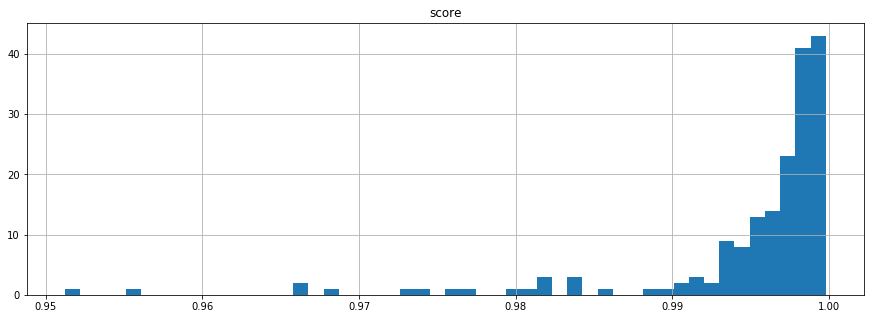

In [23]:
df.hist('score', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15479A70>]],
      dtype=object)

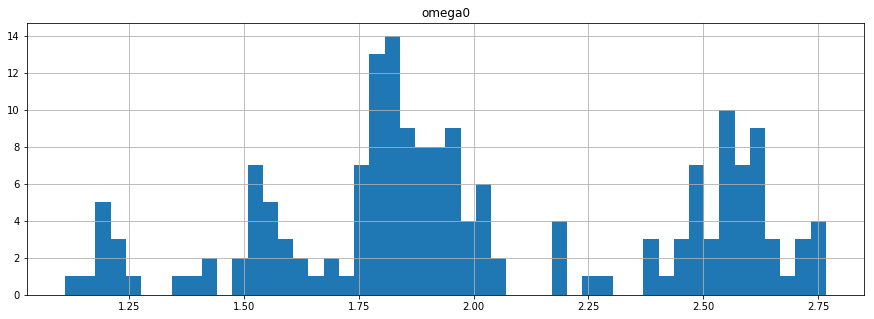

In [24]:
data.hist('omega0', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x165D9350>]],
      dtype=object)

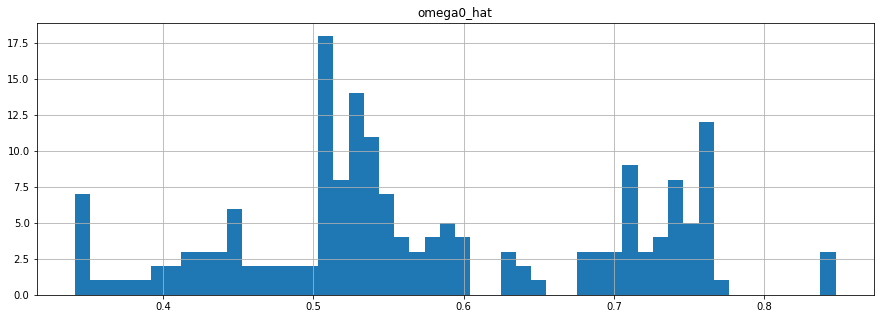

In [25]:
data.hist('omega0_hat', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16A85590>]],
      dtype=object)

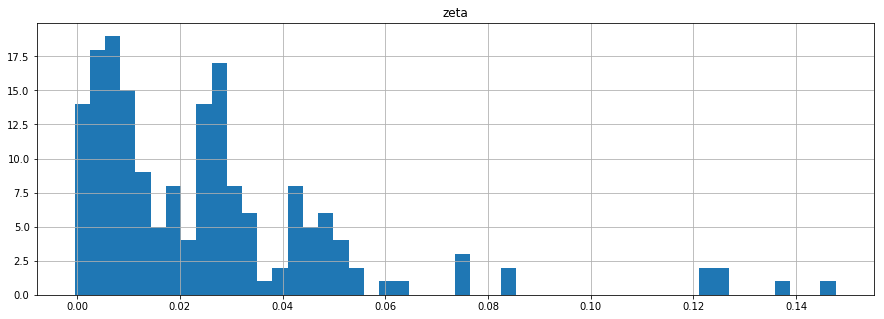

In [26]:
data.hist('zeta', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x154B7090>]],
      dtype=object)

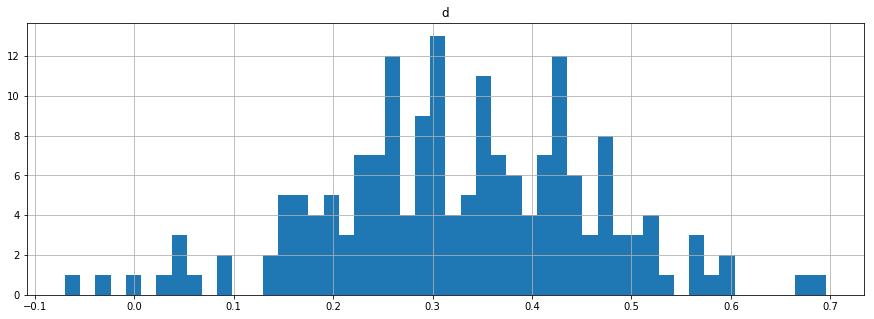

In [27]:
data.hist('d', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16A85230>]],
      dtype=object)

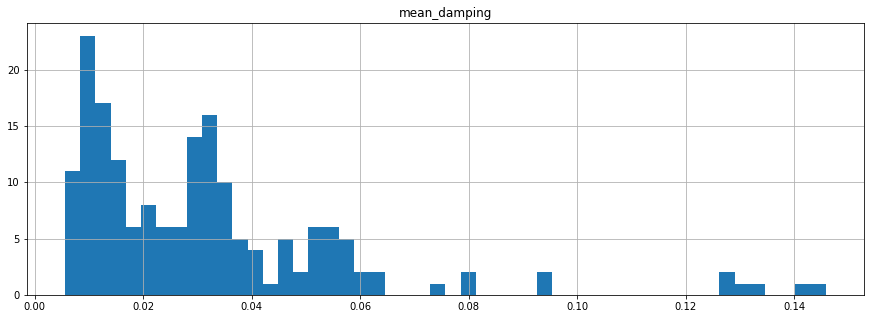

In [28]:
data.hist('mean_damping', bins = 50)

In [29]:
X=data.drop(columns=['zeta','d','omega0','mean_damping'])

In [30]:
variance_treshold = VarianceThreshold(0.001)
X_ = variance_treshold.fit_transform(X)

In [31]:
X.shape

(178, 23)

In [32]:
X_.shape

(178, 10)

In [33]:
X_ = variance_treshold.fit_transform(X)
X_.shape

(178, 10)

In [34]:
X.columns[variance_treshold.get_support()]

Index(['CW', 'TWIN', 'IRUD', 'A0', 'CP', 'ship_type_id', 'ship_speed', 'BKL',
       'rho', 'omega0_hat'],
      dtype='object')

In [35]:
GM = data['gm']
rxx = data['KXX']
kxx = rxx/data['beam']
rho = data['rho']
m = rho*data['Volume']
Ixx = m*rxx**2
data['Ixx']=Ixx
if not 'Ixx' in important:
    important.append('Ixx')
g = data['g']
omega0 = data['omega0']
data['Ixx_tot'] = Ixx_tot = GM*g*m/(omega0**2)
data['Ixx_added'] = Ixx_added = Ixx_tot - Ixx

In [36]:
mask = data['Ixx_added']>0
data = data.loc[mask].copy()

In [50]:
variance_treshold = VarianceThreshold(0.0001)
select_k_best = SelectKBest(k=5, score_func=f_regression)

standard_scaler = StandardScaler()
polynomial_features = PolynomialFeatures(degree=1)
linear_regression = LinearRegression()

steps=[
    ('variance_treshold',variance_treshold),
    ('select_k_best',select_k_best),
    ('standard_scaler', standard_scaler),
    ('polynomial_feature', polynomial_features),
    ('linear_regression', linear_regression)
]
model = Pipeline(steps=steps)

y_key = 'omega0_hat'
y=data[y_key]
X=data[important]
model.fit(X=X, y=y)


#X2 = X.copy()
#X2['omega0'] = model.predict(X=X)



Pipeline(memory=None,
         steps=[('variance_treshold', VarianceThreshold(threshold=0.0001)),
                ('select_k_best',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x13D3EF18>)),
                ('standard_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial_feature',
                 PolynomialFeatures(degree=1, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Text(0.5, 1.0, 'Historgram: omega0_hat')

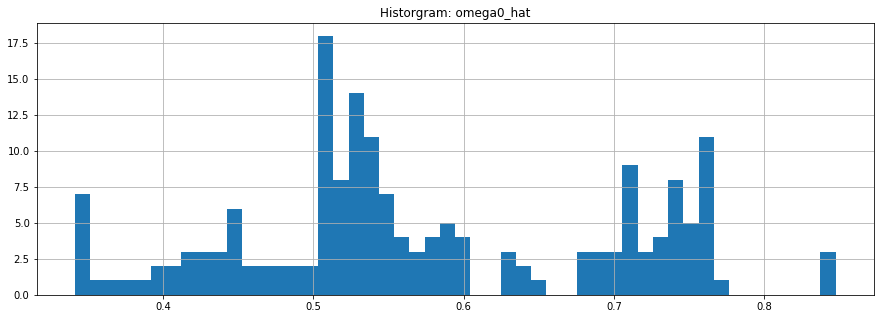

In [51]:
fig,ax=plt.subplots()
data[y_key].hist(bins=50, ax=ax)
ax.set_title('Historgram: %s' % y_key)

In [52]:
ks = np.arange(1,10)
degrees = np.arange(1,3)
results = pd.DataFrame()

for k in ks:
    for degree in degrees:
        select_k_best = SelectKBest(k=k, score_func=f_regression)
        
        standard_scaler = StandardScaler()
        polynomial_features = PolynomialFeatures(degree=degree)
        linear_regression = LinearRegression()
        
        steps=[
            ('polynomial_feature', polynomial_features),
            ('standard_scaler', standard_scaler),
            ('variance_treshold',variance_treshold),
            ('select_k_best',select_k_best),
            ('linear_regression', linear_regression)
        ]
        
        model = Pipeline(steps=steps)
        score = cross_val_score(estimator=model,X=X,y=y,cv=5).mean()
        s = pd.Series()
        s['k'] = k
        s['degree'] = degree
        s['score'] = score
        results = results.append(s, ignore_index=True)
        
        

In [53]:
results.sort_values(by='score', ascending=False, inplace=True)

In [54]:
results.head()

,degree,k,score
17,2.0,9.0,0.898610
15,2.0,8.0,0.892600
11,2.0,6.0,0.838483
4,1.0,3.0,0.821605
2,1.0,2.0,0.819312


In [55]:
k = int(results.iloc[0]['k'])
degree = int(results.iloc[0]['degree'])

In [56]:
degree

2

In [57]:
select_k_best = SelectKBest(k=k, score_func=f_regression)

standard_scaler = StandardScaler()
polynomial_features = PolynomialFeatures(degree=degree)
linear_regression = LinearRegression()

steps=[
    ('polynomial_feature', polynomial_features),
    ('standard_scaler', standard_scaler),
    ('variance_treshold',variance_treshold),
    ('select_k_best',select_k_best),
    ('linear_regression', linear_regression)
]

model = Pipeline(steps=steps)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model.fit(X=X_train, y=y_train)
score = model.score(X=X_test, y=y_test)
score

0.9715981285826724

Text(0, 0.5, 'predicted: omega0_hat')

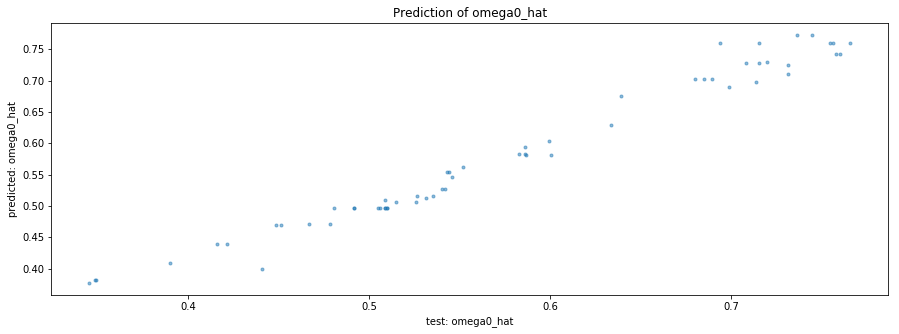

In [59]:
fig,ax = plt.subplots()
ax.plot(y_test,model.predict(X_test),'.', alpha=0.5)
ax.set_title('Prediction of %s' % y_key)
ax.set_xlabel('test: %s' % y_key)
ax.set_ylabel('predicted: %s' % y_key)
